# **TP N°3 : Méta-heuristiques pour la résolution du problème du FSP**

## **Table de matières**
* [Importations et heuristiques](#chapter0)
* [Recherche locale itérée](#chapter1)
    * [implémentaion](#section_1_1)
    * [Tests](#section_1_2) 
* [Recherche Tabou](#chapter2)
    * [implémentaion](#section_2_1)
    * [Tests](#section_2_2) 
* [Recherche par voisinage : GVNS](#chapter3)
    * [implémentaion](#section_3_1)
    * [Tests](#section_3_2) 
* [Recherche adaptative GRASP](#chapter4)
    * [implémentaion](#section_4_1)
    * [Tests](#section_4_2) 
* [Comparaison](#chapter5)
    * [Temps d'exécution](#section_5_1)
    * [Déviation](#section_5_2)

# **Importations et heuristiques** <a class="anchor" id="chapter0"></a>

In [1]:
import numpy as np
import pandas as pd
from pyscheduling.FS import FmCmax, FlowShop
import pickle
import time
import matplotlib.pyplot as plt
import numpy as np
import random

## Makespan

In [2]:
def compute_makespan(schedule, p):
    _, m = p.shape
    n = len(schedule)
    c = [[0]*m for i in range(n)]
    for i in range(n):
        for j in range(m):
            if i == 0 and j == 0:
                c[i][j] = p[schedule[i]][j]
            elif i == 0:
                c[i][j] = c[i][j-1] + p[schedule[i]][j]
            elif j == 0:
                c[i][j] = c[i-1][j] + p[schedule[i]][j]
            else:
                c[i][j] = max(c[i][j-1], c[i-1][j]) + p[schedule[i]][j]
    return c[n-1][m-1]

## Heuristiques (pour l'initialisation)

In [3]:
def heuristique_Ham(M):
    m = M.shape[1]

    P1 = np.sum(M[:,:m//2], axis=1) # somme des durées sur la première machine
    P2 = np.sum(M[:,m//2:], axis=1) # somme des durées sur la deuxième machine
    P2_P1 = P2 - P1 # différence entre les deux sommes
    ordre = np.flip(np.argsort(P2_P1)) # tri par ordre décroissant

    # Première solution
    ordre_1 = ordre
    Cmax1 = compute_makespan(ordre_1 , M) # makespan de la première solution

    # Deuxième solution
    indice_positif = ordre[P2_P1[ordre] >= 0] # indices des tâches avec un indice positif ou nul
    indice_negatif = ordre[P2_P1[ordre] < 0] # indices des tâches avec un indice négatif

    indice_positif = [indice_positif[i] for i in np.argsort(P1[indice_positif])] # tri croissant selon P1
    indice_negatif = [indice_negatif[i] for i in np.flip(np.argsort(P2[indice_negatif]))] # tri décroissant selon P2
   
    ordre_2 = [int(i) for i in np.concatenate((indice_positif, indice_negatif))]
    Cmax2 = compute_makespan(ordre_2 , M) # makespan de la deuxième solution

    if (Cmax1 > Cmax2):
        return ordre_1, Cmax1
    else:
        return ordre_2, Cmax2
    

def heuristique_NEH(M):
    n , m = M.shape
    p = M.copy()

    # Step 1: Compute the processing time of each job
    processing_time = [sum(p[i]) for i in range(n)]

    # Step 2: Sort the jobs in decreasing order of processing time
    sorted_jobs = sorted(range(n), key=lambda i: processing_time[i], reverse=True)

    # Step 3: Initialize the schedule with the first job
    schedule = [sorted_jobs[0]]

    # Step 4: Insert each subsequent job into the schedule in a position that minimizes the makespan
    for i in range(1, n):
        best_pos = -1
        best_makespan = float('inf')
        for j in range(len(schedule)+1):
            temp_schedule = schedule[:j] + [sorted_jobs[i]] + schedule[j:]
            temp_makespan = compute_makespan(temp_schedule, p)
            if temp_makespan < best_makespan:
                best_makespan = temp_makespan
                best_pos = j
        schedule.insert(best_pos, sorted_jobs[i])

    return schedule, compute_makespan(schedule, p)


def johnson_method(processing_times):
    
    jobs, machines = processing_times.shape
    #print(jobs,machines)
    copy_processing_times = processing_times.copy()
    maximum = processing_times.max() + 1
    m1 = []
    m2 = []
    
    if machines != 2:
        raise Exception("Johson method only works with two machines")
        
    for i in range(jobs):
        minimum = copy_processing_times.min()
        position = np.where(copy_processing_times == minimum)
        
        if position[1][0] == 0:
            m1.append(position[0][0])
        else:
            m2.insert(0, position[0][0])
        
        copy_processing_times[position[0][0]] = maximum
        # Delete the job appended
    return m1+m2


def heuristique_CDS(M):
    m = M.shape[1]
    solutions = []
    makespans = []

    for k in range(1,m):
        P1 = M[:,0:k].sum(axis=1) # sommer les durées sur les k premières machines
        P2 = M[:,m-k:m].sum(axis=1) # sommer les durées sur les m-k dernières machines
        P1_P2 = np.hstack([P1[:,None],P2[:,None]]) # créer une matrice à deux colonnes avec P1 et P2

        johnson_seq = johnson_method(P1_P2) # appliquer la méthode de Johnson sur P1_P2

        solutions.append(johnson_seq)
        makespans.append(np.apply_along_axis(compute_makespan, 0, johnson_seq, M)) # calculer le makespan de v avec M

    score = np.min(makespans) # trouver le score minimal
    return solutions[np.argmin(makespans)], score # renvoyer la solution correspondant au score minimal

# **1. Recherche locale itérée ou Iterated Local Search (ILS) proposée par dong et al (2009)** <a class="anchor" id="chapter1"></a>

##### (https://sci-hub.ru/10.1016/j.cor.2008.04.001)

## **Implémentation** <a class="anchor" id="section_1_1"></a>

### Utils

In [4]:
def perform_insert(schedule, i, j):
    """
    Performs an INSERT move on the given permutation by moving the job at
    position i to position j.
    
     - i: the position of the job to be moved.
     - j: the position where the job should be inserted.
    """
    schedule=list(schedule)
    new_schedule = schedule.copy()
    job = new_schedule.pop(i)
    new_schedule.insert(j, job)
    return new_schedule

def pairwise_permute_n(schedule, n_perturb):
    """
    Performs n random pairwise permutations between elements in a list.
    
    """
    new_schedule = schedule.copy()
    for i in range(n_perturb):
        idx1, idx2 = random.sample(range(len(new_schedule)), 2)
        new_schedule[idx1], new_schedule[idx2] = new_schedule[idx2], new_schedule[idx1]
    return new_schedule

# job here is the index of job in the schedule not the job 
# saying schedule [3,0,2,1]  job=1 is 3, job =2 is 0 ...
def completeion_time_of_job(machine,job,schedule,processing_times):
    if(job==1):
        cmp=0
        for r in range(machine):
            cmp=cmp+processing_times[schedule[0]][r]
        return cmp
    elif(machine==1):
        cmp=0
        for r in range(job):
            cmp=cmp+processing_times[schedule[r]][0]
        return cmp
    else:
        e1=completeion_time_of_job(machine-1,job,schedule,processing_times)
        e2=completeion_time_of_job(machine,job-1,schedule,processing_times)
        return processing_times[job-1][machine-1]+max(e1,e2)

### L'algorithme ILS

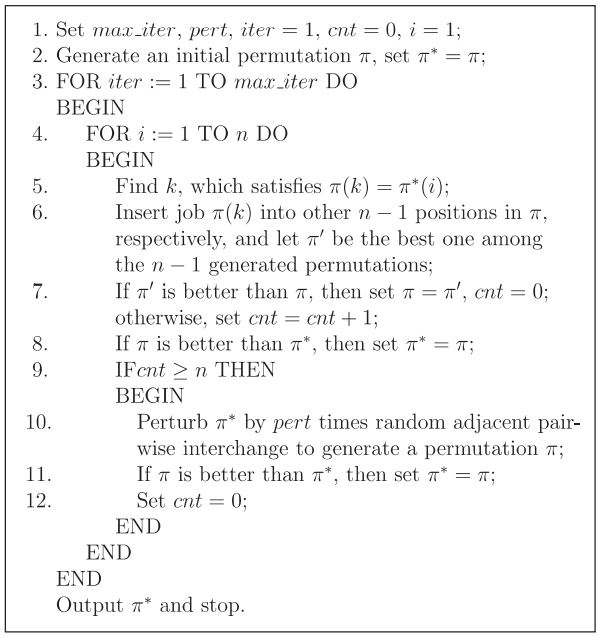

In [21]:
def dong_et_al_ils(schedule,processing_times,max_iter,n_perturb):
    n_jobs , n_machines = processing_times.shape
    cnt=0
    schedule=list(schedule)
    schedule_best=schedule.copy()
    
    for itr in range(max_iter):
        # for j in range(n_jobs):
            
            # #selecting the k
            # k=schedule.index(schedule_best[j])#step 5 of the algorithm
            # obj = 0
            # schedule_optim=schedule.copy()
            # for e in range(n_jobs):
            #     if (k!=e) :
            #         new_schedule=perform_insert(schedule, k, e)
            #         new_obj = compute_makespan(new_schedule, processing_times)
            #         if(new_obj<obj):
            #             schedule_optim=new_schedule.copy()
            #             obj = new_obj

            schedule_optim = local_search(combined_destruction_construction(schedule,7, processing_times),processing_times)
            # schedule_optim = 
            # new_obj = compute_makespan(new_schedule, processing_times)

            #step 7
            if(compute_makespan(schedule_optim, processing_times)<compute_makespan(schedule, processing_times)):
                schedule=schedule_optim.copy()
                cnt=0
            else:
                cnt=cnt+1

            if(compute_makespan(schedule, processing_times)<compute_makespan(schedule_best, processing_times)):
                schedule_best=schedule.copy()

            if(cnt>=n_jobs):
                ss=pairwise_permute_n(schedule_best, n_perturb)
                if(compute_makespan(ss, processing_times)<compute_makespan(schedule_best, processing_times)):
                    schedule_best=ss.copy()
                cnt=0
    return schedule_best,compute_makespan(schedule_best, processing_times)

## **Tests et analyse** <a class="anchor" id="section_1_2"></a>

###  **Sur l'instance aléatoire**  :

Avec l'instance aléatoire qui a comme fonction objectif optimale : **1102**, nous avons exécuté une recherche locale itérée sur une solution donnée par des heuristiques telles que : Ham et NEH ILS a amélioré cette solution de **1107** vers **1105** comme fonction objectif, avec les paramètres de l'algorithme fixés à 1000 itérations et 4 perturbations, il est à noter que la variation des paramètres n'a pas influencé la solution donnée par ILS pour cette instance, les résultats sont montrés ci-dessous :

In [31]:
instance=FmCmax.FmCmax_Instance.read_txt("../TP02-Heuristiques/data/random_instance.txt")
processing_times = np.array(instance.P)

#Run the algorithms
# schedule_ham, makespan_ham = heuristique_Ham(processing_times)
# schedule_ils_ham, makespan_ils_ham = dong_et_al_ils(schedule_ham, processing_times, 1000, 4)
schedule_neh, makespan_neh = heuristique_NEH(processing_times)
schedule_ils_neh, makespan_ils_neh = dong_et_al_ils(schedule_neh, processing_times, 1000, 7)
print(makespan_ils_neh)

# # Plot the results as a bar chart
# labels = ['Heuristique Ham', 'ILS + Ham', 'Heuristique NEH', 'ILS + NEH']
# makespans = [makespan_ham, makespan_ils_ham, makespan_neh, makespan_ils_neh]
# colors = ['tab:reD', 'tab:blue', 'tab:red', 'tab:blue']

# plt.bar(labels, makespans, color=colors)
# plt.ylabel('Makespan')
# plt.title('Comparaison des solutions pour différentes initialisations et optimisations')

# # Set the minimum value of the y-axis to 1000
# plt.ylim(bottom=1000)

# # Add the values as text above the bars
# for i, v in enumerate(makespans):
#     plt.text(i, v + 1, str(v), ha='center')

# plt.show()


1103


### **Sur les instances de Taillard** :
Dans cette section, nous allons tester l'effet des différents paramètres initiaux :
- Nombre d'itérations : de 100 à 1000 itérations.
- Intensité de perturbatios : de 4 à 7 perturbations, car d'après l'article, il est plus approprié de fixer l'intensité de la perturbation entre 4 et 7.

Ainsi que les différentes initalisations :
- Ham.
- NEH.
- CDS.

Sur la performance de ILS avec les **10 instances** du **premier Benchmark de Taillard**.

In [32]:
f =  open("../TP02-Heuristiques/data/Taillard.pkl", "rb")
taillard = pickle.load(f)


### Nombre d'itérations & Déviation avec la première instance du Benchmark:
Les autres paramètres sont fixés ainsi : 
- Initialisation : CDS.
- Nombre de perturbations : 4.

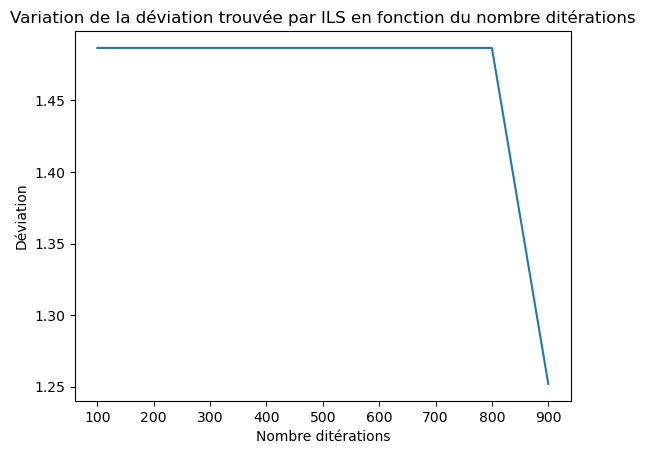

In [33]:

nb_perturb=4
processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
init_schedule,init_obj=heuristique_CDS(processing_times)
iter=[]
dev=[]

for max_iter in range(100,1000,100):
    iter.append(max_iter)
    schedule,obj=dong_et_al_ils(init_schedule,processing_times,max_iter,nb_perturb)
    dev.append(100*(compute_makespan(schedule,processing_times)-upper_bound)/upper_bound)

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(iter, dev)

# Add axis labels and a title
ax.set_xlabel('Nombre ditérations')
ax.set_ylabel('Déviation')
ax.set_title('Variation de la déviation trouvée par ILS en fonction du nombre ditérations')

# Display the graph
plt.show()

### Intensité de perturbation & déviation avec la première instance du Benchmark :
Les autres paramètres sont fixés comme suit : 
- Initialisation : Ham.
- Nombre d'itérations : 500.

In [34]:
max_iter=1000
processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
init_schedule,init_obj=heuristique_Ham(processing_times)
perturb=[]
dev=[]
times=[]
for nb_perturb in range(1,15,1):
    perturb.append(nb_perturb)
    start_time = time.time()
    schedule,obj=dong_et_al_ils(init_schedule,processing_times,max_iter,nb_perturb)
    end_time = time.time()
    dev.append(100*(compute_makespan(schedule,processing_times)-upper_bound)/upper_bound)
    elapsed_time = end_time - start_time
    times.append(elapsed_time)

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(perturb, dev)

# Add axis labels and a title
ax.set_xlabel('Intensité de perturbation')
ax.set_ylabel('Déviation')
ax.set_title('Variation de la déviation trouvée par ILS en fonction de lintensité de perturbation')

# Display the graph
plt.show()

KeyboardInterrupt: 

### Conclusion sur l'effet des deux paramètres : 
Vu la nature aléatoire de l'algorithme dans la phase des perturbations, on ne peut pas généraliser l'effet du nombre des itérations sur la déviation obtenue par rapport aux instances de Taillard, mais le nombre de perturbations a clairement un effet sur la performance de l'algorithme, trop pertuber va donner un caractère aléatoire excessif à l'algorithme qui ne sera pas bon pour l'optimisation, mais si l'intensité de perturbation est trop faible, l'algorithme aura relativement peu de chances de sortir d'une zone locale.

### Effet de la méthode d'initialisation sur la déviation obtenue :
Dans ce test, nous allons initialiser avec Ham et NEH pour les 10 instances du 1er Benchmark en fixant le nombre d'itérations à 600 et l'intensité de perturbation à 4, nous enregitrons aussi le temps d'exécution de la méthode afin de pouvoir comparer les méthodes obtenues à la fin.

In [35]:
max_iter=1000
nb_perturb=4
dev_Ham=[]
dev_NEH=[]
dev_CDS=[]
dev_ham_ils=[]
dev_neh_ils=[]
dev_cds_ils=[]
times_ils=[]     
instances=list(range(1,11))
for i in range(10):
    processing_times = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    # schedule_ham, makespan_ham = heuristique_Ham(processing_times)
    # schedule_ils_ham, makespan_ils_ham = dong_et_al_ils(schedule_ham, processing_times, max_iter, nb_perturb)
    schedule_neh, makespan_neh = heuristique_NEH(processing_times)
    schedule_ils_neh, makespan_ils_neh = dong_et_al_ils(schedule_neh, processing_times, max_iter, nb_perturb)
    # schedule_cds, makespan_cds = heuristique_CDS(processing_times)
    # start_time = time.time()
    # schedule_ils_cds, makespan_ils_cds = dong_et_al_ils(schedule_cds, processing_times, max_iter, nb_perturb)
    # end_time = time.time() 
    # elapsed_time = end_time - start_time
    # times_ils.append(elapsed_time)
    # dev_Ham.append(100*(makespan_ham-upper_bound)/upper_bound)
    # dev_NEH.append(100*(makespan_neh-upper_bound)/upper_bound)
    # dev_CDS.append(100*(makespan_cds-upper_bound)/upper_bound)
    # dev_ham_ils.append(100*(makespan_ils_ham-upper_bound)/upper_bound)
    dev_neh_ils.append(100*(makespan_ils_neh-upper_bound)/upper_bound)
    print(100*(makespan_ils_neh-upper_bound)/upper_bound)
    # dev_cds_ils.append(100*(makespan_ils_cds-upper_bound)/upper_bound)

0.6259780907668232
0.44150110375275936
4.995374653098982
2.474864655839134
0.4854368932038835
1.3389121338912133
0.9685230024213075
1.4096185737976783
4.065040650406504
3.88086642599278


In [30]:
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)



fig = go.Figure()

fig.add_trace(go.Bar(
    x=instances,
    y=dev_Ham,
    name='Ham',
    marker_color='#176ab4'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_ham_ils,
    name='Ham+ILS',
    marker_color='#4b9cd3'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_CDS,
    name='CDS',
    marker_color='#6c3483'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_cds_ils,
    name='CDS+ILS',
    marker_color='#9b59b6'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_NEH,
    name='NEH',
    marker_color='#6b9c34'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_neh_ils,
    name='NEH+ILS',
    marker_color='#8cc63f'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45, xaxis_title ="Instance", yaxis_title="Deviation (%)", title_text="Déviations obtenues par ILS avec différentes initialisations heuristiques")
fig.show()

# **2. Recherche Taboue : Tabu Search (TS)** <a class="anchor" id="chapter2"></a>

##  **Implémentation:** <a class="anchor" id="section_2_1"></a>
1. Initialiser la liste de tabous et définir la solution initiale comme solution courante.
2. Définir une structure de voisinage qui génère des solutions candidates en échangeant les tâches adjacentes dans la solution courante.
3. Évaluer la qualité de la solution initiale à l'aide d'une fonction objective qui mesure le temps de traitement total sur toutes les machines.
4. Répétez l'opération jusqu'à ce qu'un critère d'arrêt soit rempli :\
    a. Générer un ensemble de solutions candidates en appliquant la structure de voisinage à la solution actuelle.\
    b. Supprimer toutes les solutions candidates qui se trouvent dans la liste de tabou.\ 
    c. Évaluer les solutions candidates restantes à l'aide de la fonction objective.\   
    d. Sélectionner la meilleure solution candidate comme nouvelle solution courante.\   
    e. Mettre à jour la liste de tabous avec la solution actuelle.\  
    f. Si la nouvelle solution actuelle est meilleure que la meilleure solution trouvée jusqu'à présent, mettre à jour la meilleure solution.
5. Renvoyer la meilleure solution trouvée.


In [10]:
def tabu_search(init_schedule,processing_times, neighbors_size=10, max_iter=1000, tabu_size=10):
    
    n_jobs , n_machines = processing_times.shape
    current_schedule = init_schedule.copy()
    best_schedule = init_schedule.copy()
    
    tabu_list = []
    
    iter = 0
    for _ in range(max_iter):
        
        # Générer un ensemble de solutions candidates
        candidates = []
        for i in range(neighbors_size):
            candidate = current_schedule.copy()
            j = random.randint(0, n_jobs-2)
            k = random.randint(j+1, n_jobs-1)
            candidate[j:k+1] = reversed(candidate[j:k+1])
            
            # Supprimer le candidat s'il figure dans la liste taboue
            if(candidate not in tabu_list):
                candidates.append(candidate)
        
        # Évaluer les solutions candidates restantes
        candidate_scores = [compute_makespan(candidate, processing_times) for candidate in candidates]
        
        # Sélectionner la meilleure solution candidate comme nouvelle solution actuelle
        best_candidate_idx = min(range(len(candidate_scores)), key=lambda i: candidate_scores[i])
        current_schedule = candidates[best_candidate_idx]
        
        # Ajouter la solution actuelle à la liste taboue
        tabu_list.append(current_schedule.copy())
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)
            
        # Vérifier si le meilleur candidat est meilleur que la solution actuelle
        if candidate_scores[best_candidate_idx] < compute_makespan(best_schedule, processing_times):
            best_schedule = current_schedule.copy()

    return best_schedule

## **Tests :** <a class="anchor" id="section_2_2"></a>

### **Sur l'instance aléatoire :**
Dans un premier lieu, nous avons exécuté la recherche tabou sur une instance générée aléatoirement qui a pour solution optimale **1102**, avec différentes initailisations heuristiques et des paramètres initiaux fixés à :
- Nombre d'itérations : 5000.
- Taille de la liste taboue : 100.
- Taille de voisinage : 20.

La recherche Tabou avec ces paramètres atteint toujours la meilleure solution avec une déviation nulle comme montré ci-sessous.

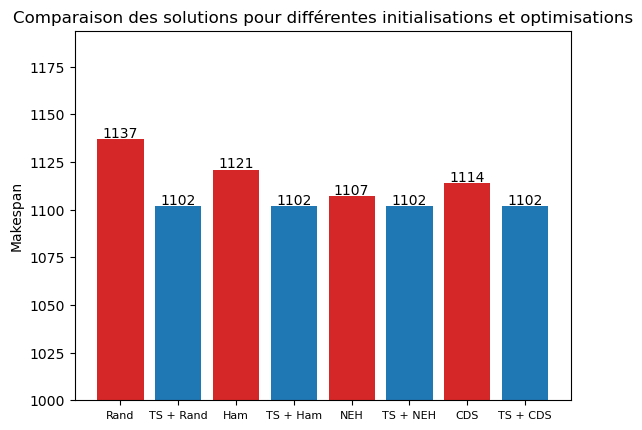

In [17]:
instance=FmCmax.FmCmax_Instance.read_txt("../TP02-Heuristiques/data/random_instance.txt")
processing_times = np.array(instance.P)

#Run the algorithms
schedule_rand = list(range(10))
random.shuffle(schedule_rand)
makespan_rand=compute_makespan(schedule_rand,processing_times)
makespan_ts_rand=compute_makespan(tabu_search(schedule_rand, processing_times,neighbors_size=20, max_iter=5000, tabu_size=100),processing_times)
schedule_ham, makespan_ham = heuristique_Ham(processing_times)
makespan_ts_ham = compute_makespan(tabu_search(schedule_ham, processing_times,neighbors_size=20, max_iter=5000, tabu_size=100),processing_times)
schedule_neh,makespan_neh = heuristique_NEH(processing_times)
makespan_ts_neh = compute_makespan(tabu_search(schedule_neh, processing_times,neighbors_size=20, max_iter=5000, tabu_size=100),processing_times)
schedule_cds,makespan_cds = heuristique_CDS(processing_times)
makespan_ts_cds = compute_makespan(tabu_search(schedule_cds, processing_times,neighbors_size=20, max_iter=5000, tabu_size=100),processing_times)

# Plot the results as a bar chart
labels = ['Rand','TS + Rand','Ham', 'TS + Ham', 'NEH', 'TS + NEH','CDS','TS + CDS']
makespans = [makespan_rand,makespan_ts_rand,makespan_ham, makespan_ts_ham, makespan_neh, makespan_ts_neh,makespan_cds,makespan_ts_cds]
colors = ['tab:red','tab:blue','tab:red','tab:blue','tab:red','tab:blue','tab:red','tab:blue']

plt.bar(labels, makespans, color=colors)
plt.ylabel('Makespan')
plt.title('Comparaison des solutions pour différentes initialisations et optimisations')

plt.xticks(fontsize=8)
# Set the minimum value of the y-axis to 1000
plt.ylim(bottom=1000)

# Add the values as text above the bars
for i, v in enumerate(makespans):
    plt.text(i, v + 1, str(v), ha='center')

plt.show()


### **Sur les instances du premier Benchmark de Taillard**
Dans cette section, nous allons tester l'effet des différentes initalisations :
- Aléatoire.
- NEH.
- CDS.

Sur la performance de la recherche Tabou avec les **10 instances** du **premier Benchmark de Taillard**, en calculant la déviation par rapport à la meilleure solution trouvée par Taillard.

Nous avons commencé par tester l'effet des paramètres initiaux sur la performance de la recherche taboue, y compris : 
- Le nombre d'itérations.
- La taille de la liste tabou.
- La taille de voisinage.

### Nombre d'itérations & déviation :
Avec :
- Taille de la liste taboue = 10
- Taille du voisinage = 10
- Initialisation : CDS

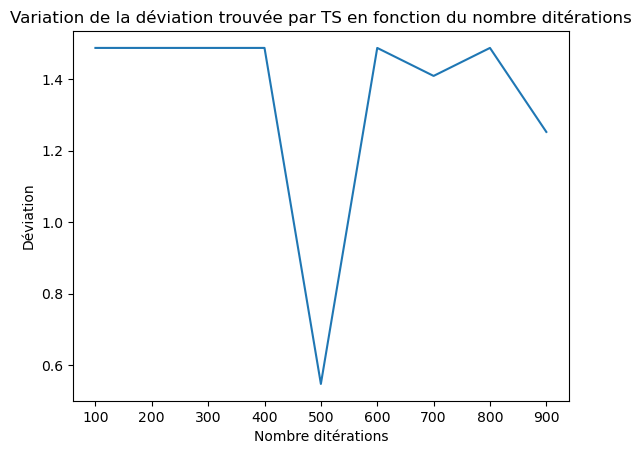

In [22]:

tabu_size=10
neighbors_size=10
processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
init_schedule,init_obj=heuristique_CDS(processing_times)
iter=[]
dev=[]

for max_iter in range(100,1000,100):
    iter.append(max_iter)
    makespan_ts_cds = compute_makespan(tabu_search(init_schedule, processing_times,neighbors_size, max_iter, tabu_size),processing_times)
    dev.append(100*(makespan_ts_cds-upper_bound)/upper_bound)

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(iter, dev)

# Add axis labels and a title
ax.set_xlabel('Nombre ditérations')
ax.set_ylabel('Déviation (%)')
ax.set_title('Variation de la déviation trouvée par TS en fonction du nombre ditérations')

# Display the graph
plt.show()

**Interprétaion :** il est clair que l'effet du nombre d'itérations n'affecte pas vraiment le résultat obtenu, d'après la variance de la déviation du graphe précédent, et le fait que chaque exécution donne un résultat différent (grace au caratère aléatoire des perturbations utilisées de la méthode) avec une petite variance voire négligeable. 

### Effet de la taille de la liste Tabou
Avec : 
- Nombre d'itérations = 1000
- Taille du voisinage = 10
- Initialisation : CDS

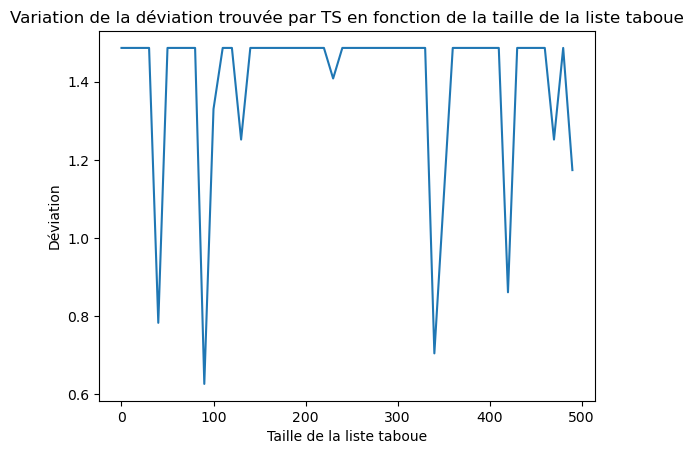

In [30]:

tabu_size=0
max_iter=500
neighbors_size=10
processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
init_schedule,init_obj=heuristique_CDS(processing_times)
size=[]
dev=[]

for tabu_size in range(0,500,10):
    size.append(tabu_size)
    makespan_ts_cds = compute_makespan(tabu_search(init_schedule, processing_times,neighbors_size, max_iter, tabu_size),processing_times)
    dev.append(100*(makespan_ts_cds-upper_bound)/upper_bound)

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(size, dev)

# Add axis labels and a title
ax.set_xlabel('Taille de la liste taboue')
ax.set_ylabel('Déviation (%)')
ax.set_title('Variation de la déviation trouvée par TS en fonction de la taille de la liste tabou')

# Display the graph
plt.show()

### Effet de la taille du voisinage 
Avec : 
- Nombre d'itérations = 500
- Taille e la liste Taboue = 10
- Initialisation : CDS

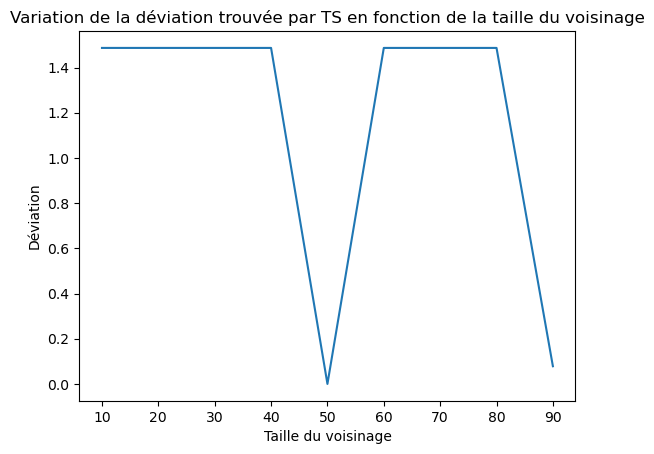

In [34]:

tabu_size=10
max_iter=500
neighbors_size=10
processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
init_schedule,init_obj=heuristique_CDS(processing_times)
neighb=[]
dev=[]

for neighbors_size in range(10,100,10):
    neighb.append(neighbors_size)
    makespan_ts_cds = compute_makespan(tabu_search(init_schedule, processing_times,neighbors_size, max_iter, tabu_size),processing_times)
    dev.append(100*(makespan_ts_cds-upper_bound)/upper_bound)

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(neighb, dev)

# Add axis labels and a title
ax.set_xlabel('Taille du voisinage')
ax.set_ylabel('Déviation (%)')
ax.set_title('Variation de la déviation trouvée par TS en fonction de la taille du voisinage')

# Display the graph
plt.show()

### Effet de la méthode d'initalisation 
Avec :
- Nombre d'itérations = 500
- Taille du voisinage = 50
- Taille de la liste tabou = 50

In [14]:
f =  open("../TP02-Heuristiques/data/Taillard.pkl", "rb")
taillard = pickle.load(f)
i=0
max_iter=500
tabu_size=50
neighbors_size=50
dev_rand=[]
dev_Ham=[]
dev_NEH=[]
dev_CDS=[]
dev_rand_ts=[]
dev_ham_ts=[]
dev_neh_ts=[]
dev_cds_ts=[]
times_ts=[]
instances=list(range(1,11))
for i in range(10):
    processing_times = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    schedule_rand = list(range(20))
    random.shuffle(schedule_rand)
    makespan_rand=compute_makespan(schedule_rand,processing_times)
    makespan_ts_rand=compute_makespan(tabu_search(schedule_rand, processing_times,neighbors_size=20, max_iter=5000, tabu_size=100),processing_times)
    schedule_neh,makespan_neh = heuristique_NEH(processing_times)
    makespan_ts_neh = compute_makespan(tabu_search(schedule_neh, processing_times,neighbors_size=20, max_iter=5000, tabu_size=100),processing_times)
    start_time = time.time() 
    schedule_cds,makespan_cds = heuristique_CDS(processing_times)
    makespan_ts_cds = compute_makespan(tabu_search(schedule_cds, processing_times,neighbors_size=20, max_iter=5000, tabu_size=100),processing_times)
    end_time = time.time() 
    elapsed_time = end_time - start_time
    times_ts.append(elapsed_time)
    dev_rand.append(100*(makespan_rand-upper_bound)/upper_bound)
    dev_CDS.append(100*(makespan_cds-upper_bound)/upper_bound)
    dev_NEH.append(100*(makespan_neh-upper_bound)/upper_bound)
    dev_rand_ts.append(100*(makespan_ts_rand-upper_bound)/upper_bound)
    dev_cds_ts.append(100*(makespan_ts_cds-upper_bound)/upper_bound)
    dev_neh_ts.append(100*(makespan_ts_neh-upper_bound)/upper_bound)

In [65]:
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)



fig = go.Figure()
fig.add_trace(go.Bar(
    x=instances,
    y=dev_rand,
    name='Rand',
    marker_color='#176ab4'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_rand_ts,
    name='Rand+TS',
    marker_color='#4b9cd3'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_CDS,
    name='CDS',
    marker_color='#6c3483'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_cds_ts,
    name='CDS+ts',
    marker_color='#9b59b6'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_NEH,
    name='NEH',
    marker_color='#6b9c34'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_neh_ts,
    name='NEH+ts',
    marker_color='#8cc63f'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45, xaxis_title ="Instance", yaxis_title="Deviation (%)", title_text="Déviations obtenues par la recherche tabou avec différentes initialisations heuristiques")
fig.show()

# **3. Recherche par voisinage : General Variable Neighborhood Search (GVNS)** <a class="anchor" id="chapter3"></a>
https://sci-hub.ru/10.1007/978-3-319-03753-0_3

## **Implémentation** <a class="anchor" id="section_3_1"></a>

### Pseudo code :
Voici le pseudo-code de l'algorithme GVNS présenté dans l'article :

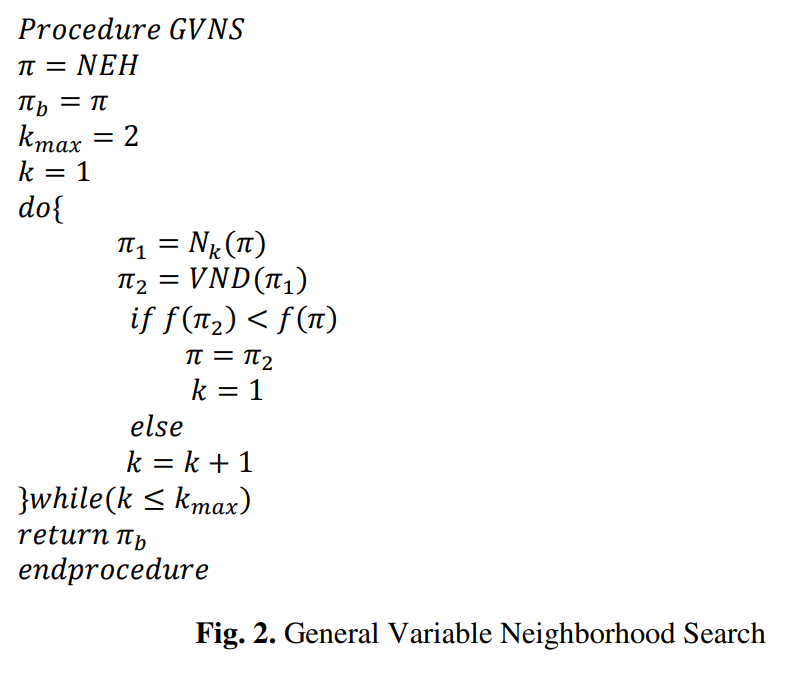

L'algorithme VND comprend les étapes suivantes :

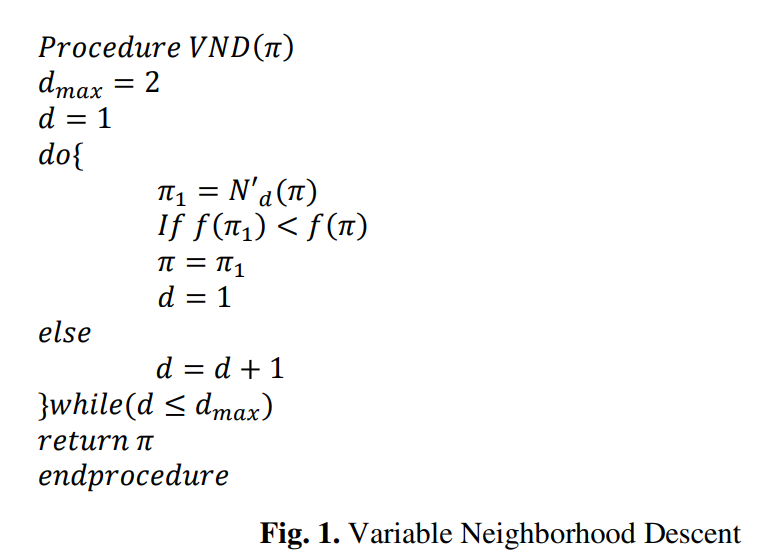

L'étape de perturbation de l'algorithme GVNS peut être mise en œuvre à l'aide de diverses techniques, telles que les mouvements de permutation et d'insertion.

**combined_destruction_construction :** cette fonction met en œuvre une variante de l'heuristique de construction pour le problème d'ordonnancement de l'atelier qui implique à la fois des étapes destructives et constructives. Elle détruit aléatoirement un sous-ensemble de travaux de la permutation courante pi, construit une permutation partielle pi_prime en supprimant les travaux détruits, puis construit une permutation complète pi_double_prime en insérant itérativement les travaux dont le délai de disponibilité est le plus court sur chaque machine de pi_prime. Les travaux détruits sont ensuite réinsérés aléatoirement dans pi_double_prime à la fin.

**Local search :** effectuer toutes les permutations possibles entre les jobs et choisir la meilleure à chaque fois si elle améliore la solution courante.

In [12]:
#utilities
def combined_destruction_construction(pi, d, processing_times):
    # Select a random subset of d jobs from the current permutation pi
    pi_d = random.sample(pi, d)
    
    # Remove the selected jobs from pi to create a partial permutation pi'
    pi_prime = [job for job in pi if job not in pi_d]
    
    # Initialize an empty permutation pi''
    pi_double_prime = []
    
    # While pi'' is not a complete permutation
    while len(pi_double_prime) != len(pi)-d:
        # For each machine i
        for i in range(processing_times.shape[1]):
            # Select the job j with the earliest available time on machine i in pi'
            jobs_on_i = [(job, processing_times[job, i]) for job in pi_prime if any(job == k for k in range(processing_times.shape[0]) if processing_times[k, i] > 0)]
            if len(jobs_on_i) > 0:
                j, _ = min(jobs_on_i, key=lambda x: x[1])
                # Insert job j at the end of pi''
                pi_double_prime.append(j)
                # Remove job j from pi'
                pi_prime.remove(j)
    
    # Insert the destructed jobs back into pi'' at random positions
    for job in pi_d:
        pos = random.randint(0, len(pi_double_prime))
        pi_double_prime.insert(pos, job)
    
    # Return the complete permutation pi''
    return pi_double_prime

def N1(schedule,processing_times):
    new_schedule=combined_destruction_construction(schedule, 4, processing_times)
    flag=True
    while(flag):
        newnew_schedule=local_search(schedule,processing_times)
        if(compute_makespan(newnew_schedule,processing_times)<compute_makespan(new_schedule,processing_times)):
            new_schedule=newnew_schedule
            flag=True
        else:
            flag=False
    return new_schedule  

def N2(schedule,processing_times,n_perturb=5):
    for _ in range(n_perturb):
        schedule=swap_perturb(schedule)
    new_schedule=schedule
    flag=True
    while(flag):
        newnew_schedule=local_search(schedule,processing_times)
        if(compute_makespan(newnew_schedule,processing_times)<compute_makespan(new_schedule,processing_times)):
            new_schedule=newnew_schedule
            flag=True
        else:
            flag=False
    return new_schedule

def RIS(schedule, processing_times):
    num_jobs,num_machines=processing_times.shape
    improved_schedule = schedule
    for i in range(len(schedule)-1):
        for j in range(i+1, len(schedule)):
            neighbor_schedule = improved_schedule
            neighbor_schedule[i], neighbor_schedule[j] = neighbor_schedule[j], neighbor_schedule[i]

            neighbor_obj = compute_makespan(neighbor_schedule, processing_times)

            if neighbor_obj < compute_makespan(improved_schedule, processing_times):
                improved_schedule = neighbor_schedule
    return improved_schedule

# local search by swapping
def local_search(schedule, processing_times):
    num_jobs,num_machines=processing_times.shape
    improved_schedule = schedule.copy()
    for i in range(num_jobs-2):
        for j in range(i+1, num_jobs):
            neighbor_schedule = improved_schedule.copy()
            neighbor_schedule[i], neighbor_schedule[j] = neighbor_schedule[j], neighbor_schedule[i]
            neighbor_obj = compute_makespan(neighbor_schedule, processing_times)
            if neighbor_obj < compute_makespan(improved_schedule, processing_times):
                improved_schedule = neighbor_schedule
    return improved_schedule

def vnd(schedule,processing_times):
    d_max=2
    d=1
    while(d<=d_max):
        if(d==1):
            new_schedule=N1(schedule,processing_times)
        else:
            new_schedule=N2(schedule,processing_times)
        if(compute_makespan(new_schedule,processing_times)<compute_makespan(schedule,processing_times)):
            schedule=new_schedule
            d=1
        else:
            d=d+1
    return schedule

def perform_insert(schedule):
    i=random.randint(0,len(schedule)-2)
    j=random.randint(i+1,len(schedule))
    schedule=list(schedule)
    new_schedule = schedule.copy()
    job = new_schedule.pop(i)
    new_schedule.insert(j, job)
    return new_schedule

def swap_perturb(schedule):
    schedule=list(schedule)
    i, j = random.sample(range(len(schedule)), 2)
    perturbed_schedule = schedule.copy()
    perturbed_schedule[i], perturbed_schedule[j] = perturbed_schedule[j], perturbed_schedule[i]
    return perturbed_schedule

In [39]:
#Main
def GVNS(schedule,processing_times,max_iter):
    best_schedule=schedule
    for ii in range(max_iter):
        kmax=2
        k=1
        while(k<=kmax):
            if(k==1):
                new_schedule=perform_insert(schedule)
            else:
                new_schedule=swap_perturb(schedule)

            new_new_schedule=vnd(new_schedule,processing_times)
            if(compute_makespan(new_new_schedule,processing_times)<compute_makespan(schedule,processing_times)):
                schedule=new_new_schedule
                k=1
            else:
                k=k+1
        if(compute_makespan(schedule,processing_times)<compute_makespan(best_schedule,processing_times)):
            best_schedule=schedule
    return best_schedule
            

## **Tests et analyse**  <a class="anchor" id="section_3_2"></a>

### **Sur l'instance aléatoire**

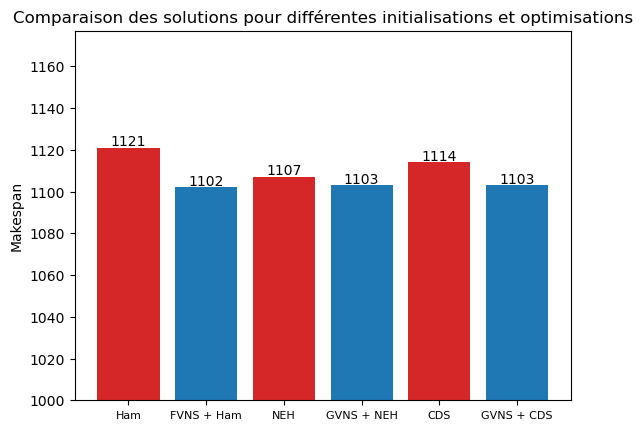

In [40]:
instance=FmCmax.FmCmax_Instance.read_txt("../TP02-Heuristiques/data/random_instance.txt")
processing_times = np.array(instance.P)
max_iter = 500
#Run the algorithms
schedule_ham, makespan_ham = heuristique_Ham(processing_times)
schedule_gvns_ham = GVNS(schedule_ham,processing_times,max_iter)
makespan_gvns_ham = compute_makespan(schedule_gvns_ham,processing_times)
schedule_neh, makespan_neh = heuristique_NEH(processing_times)
schedule_gvns_neh = GVNS(schedule_neh,processing_times,max_iter)
makespan_gvns_neh = compute_makespan(schedule_gvns_neh,processing_times)
schedule_cds, makespan_cds = heuristique_CDS(processing_times)
schedule_gvns_cds = GVNS(schedule_cds,processing_times,max_iter)
makespan_gvns_cds = compute_makespan(schedule_gvns_cds,processing_times)

# Plot the results as a bar chart
labels = ['Ham', 'FVNS + Ham', 'NEH', 'GVNS + NEH','CDS','GVNS + CDS']
makespans = [makespan_ham, makespan_gvns_ham, makespan_neh, makespan_gvns_neh,makespan_cds,makespan_gvns_cds]
colors = ['tab:red','tab:blue','tab:red','tab:blue','tab:red','tab:blue']

plt.bar(labels, makespans, color=colors)
plt.ylabel('Makespan')
plt.title('Comparaison des solutions pour différentes initialisations et optimisations')

plt.xticks(fontsize=8)
# Set the minimum value of the y-axis to 1000
plt.ylim(bottom=1000)

# Add the values as text above the bars
for i, v in enumerate(makespans):
    plt.text(i, v + 1, str(v), ha='center')

plt.show()

### **Sur les instances de Taillard**

### Nombre d'itérations et déviation 

Nous avons commencé par étuduer l'effet du nombre d'itérations sur la déviation obtenue :

In [41]:
max_iter=100
processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
iter=[]
dev=[]
times=[]
for max_iter in range(100,1000,100):
    iter.append(max_iter)
    schedule_neh, makespan_neh = heuristique_NEH(processing_times)
    schedule_gvns_neh = GVNS(schedule_neh,processing_times,max_iter)
    makespan_gvns_neh = compute_makespan(schedule_gvns_neh,processing_times)
    dev.append(100*(makespan_gvns_neh-upper_bound)/upper_bound)



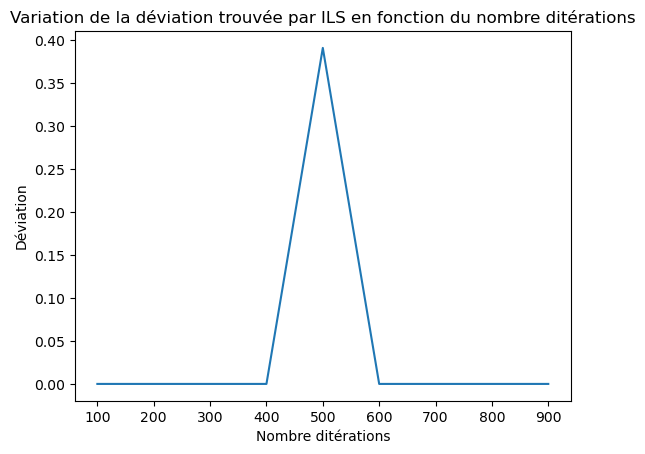

In [42]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(iter, dev)

# Add axis labels and a title
ax.set_xlabel('Nombre ditérations')
ax.set_ylabel('Déviation')
ax.set_title('Variation de la déviation trouvée par ILS en fonction du nombre ditérations')

# Display the graph
plt.show()

**Interprétation :** ous remrquons que la méthode donne une déviation inférieure à zéro voire nulle pour quelques cas quelque soit le nombre d'itérations.

De meme, nous avons abservé l'amélioration de la déviation obtenue par GVNS par rapport aux différentes initialisation heuristiques sur les 10 premières istances de Taillard :

In [ ]:
f =  open("../TP02-Heuristiques/data/Taillard.pkl", "rb")
taillard = pickle.load(f)
max_iter=500
dev_Ham=[]
dev_NEH=[]
dev_CDS=[]
dev_ham_gvns=[]
dev_neh_gvns=[]
dev_cds_gvns=[]
times_gvns=[]
instances=list(range(1,11))
for i in range(10):
    processing_times = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    schedule_ham, makespan_ham = heuristique_Ham(processing_times)
    schedule_gvns_ham = GVNS(schedule_ham,processing_times,max_iter)
    makespan_gvns_ham = compute_makespan(schedule_gvns_ham,processing_times)
    schedule_neh, makespan_neh = heuristique_NEH(processing_times)
    schedule_gvns_neh = GVNS(schedule_neh,processing_times,max_iter)
    makespan_gvns_neh = compute_makespan(schedule_gvns_neh,processing_times)
    schedule_cds, makespan_cds = heuristique_CDS(processing_times)
    start_time = time.time() 
    schedule_gvns_cds = GVNS(schedule_cds,processing_times,max_iter)
    end_time = time.time() 
    elapsed_time = end_time - start_time
    times_gvns.append(elapsed_time)
    makespan_gvns_cds = compute_makespan(schedule_gvns_cds,processing_times)
    dev_Ham.append(100*(makespan_ham-upper_bound)/upper_bound)
    dev_NEH.append(100*(makespan_neh-upper_bound)/upper_bound)
    dev_CDS.append(100*(makespan_cds-upper_bound)/upper_bound)
    dev_ham_gvns.append(100*(makespan_gvns_ham-upper_bound)/upper_bound)
    dev_neh_gvns.append(100*(makespan_gvns_neh-upper_bound)/upper_bound)
    dev_cds_gvns.append(100*(makespan_gvns_cds-upper_bound)/upper_bound)

#### Résultats

In [15]:
dev_neh_gvns=[0.0,
 0.004415011037527594,
 0.01572617946345976,
 0.004640371229698376,
 -0.0008090614886731392,
 0.0,
 0.009685230024213076,
 0.0,
 0.0,
 0.0]
dev_ham_gvns= [0.0,
 0.07358351729212656,
 1.572617946345976,
 0.07733952049497294,
 -0.08090614886731392,
 0.0,
 0.9685230024213076,
 0.0,
 0.0,
 0.0]
dev_cds_gvns=[0.0,
  0.07358351729212656,
  0.64754856614246065,
  0.30935808197989174,
  -0.08090614886731392,
  0.0,
  0.9685230024213076,
  0.0,
  0.0,
  0.0]
times_gvns=[194.25770711898804,
  184.45941352844238,
  231.95963430404663,
  261.47199273109436,
  279.78384041786194,
  302.4761984348297,
  297.67465567588806,
  344.6593589782715,
  278.51966404914856,
  311.37041330337524]


In [29]:
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)



fig = go.Figure()
fig.add_trace(go.Bar(
    x=instances,
    y=dev_Ham,
    name='Ham',
    marker_color='#176ab4'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_ham_gvns,
    name='Ham+GVNS',
    marker_color='#4b9cd3'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_CDS,
    name='CDS',
    marker_color='#6c3483'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_cds_gvns,
    name='CDS+GVNS',
    marker_color='#9b59b6'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_NEH,
    name='NEH',
    marker_color='#6b9c34'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_neh_gvns,
    name='NEH+GVNS',
    marker_color='#8cc63f'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45, xaxis_title ="Instance", yaxis_title="Deviation", title_text="Déviations obtenues par GVNS avec différentes initialisations heuristiques")
fig.show()

# **4. Procédure de recherche adaptative aléatoire et gloutonne ou Greedy Randomized Adaptive Search Procedure  (GRASP)** <a class="anchor" id="chapter4"></a>
https://www.sciencedirect.com/science/article/pii/S0305054812000482?via%3Dihub

## **Implémentation** <a class="anchor" id="section_4_1"></a>

GRASP est une technique itérative d'échantillonnage aléatoire qui fournit une solution au problème posé à chaque itération.

L'algorithme comporte deux phases à chaque itération : la première phase construit une solution initiale à l'aide d'une fonction gourmande aléatoire adaptative, et la seconde phase applique une procédure de recherche locale à la solution construite dans l'espoir de trouver une amélioration.

Voici le pseudo code de GRASP :

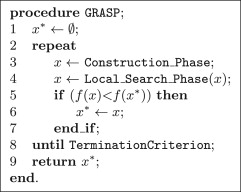



Dans un premier lieu, nous avons importé la version de GRASP disponible dans pyscheduling, cette version est donnée comme suit : : 

In [49]:
from pyscheduling.Problem import Branch_Bound
from pyscheduling.FS import FmCmax, FlowShop
import threading
import pickle
import numpy as np
from time import perf_counter
import time
import matplotlib.pyplot as plt
import random
import pyscheduling as ps
import random
import sys
from functools import partial
from math import exp
from time import perf_counter
from typing import Callable

import pyscheduling.FS.FlowShop as FS
import pyscheduling.Problem as Problem
from pyscheduling.Problem import Job
def grasp(procesing_times, p=0.5 , r=10 , n_iterations=1000):
        """Returns the solution using the Greedy randomized adaptive search procedure algorithm

        Args:
            instance (SingleInstance): The instance to be solved by the heuristic
            p (float): probability of taking the greedy best solution
            r (int): percentage of moves to consider to select the best move
            nb_exec (int): Number of execution of the heuristic

        Returns:
            Problem.SolveResult: the solver result of the execution of the heuristic
        """
        
        instance=FmCmax.FmCmax_Instance(name='',n=10,m=5,P=procesing_times)
        
        startTime = perf_counter()
        solveResult = Problem.SolveResult()
        best_solution = None
        for _ in range(n_iterations):
            solution = FS.FlowShopSolution(instance)
            remaining_jobs_list = [i for i in range(instance.n)]
            while len(remaining_jobs_list) != 0:
                insertions_list = []
                for i in remaining_jobs_list:
                    start_time, end_time = solution.simulate_insert_last(i)
                    new_obj = solution.simulate_insert_objective(i, start_time, end_time)
                    insertions_list.append((i, new_obj))

                insertions_list.sort(key=lambda insertion: insertion[1])
                proba = random.random()
                if proba < p:
                    rand_insertion = insertions_list[0]
                else:
                    rand_insertion = random.choice(
                        insertions_list[0:int(instance.n * r)])
                
                taken_job, new_obj = rand_insertion
                solution.job_schedule.append(Job(taken_job, 0, 0))
                solution.compute_objective(startIndex=len(solution.job_schedule) - 1)
                remaining_jobs_list.remove(taken_job)

            solveResult.all_solutions.append(solution)
            if not best_solution or best_solution.objective_value > solution.objective_value:
                best_solution = solution

        solveResult.best_solution = best_solution
        solveResult.runtime = perf_counter() - startTime
        solveResult.solve_status = Problem.SolveStatus.FEASIBLE
        best_schedule=[]
        [best_schedule.append(job.id) for job in solveResult.all_solutions[0].machines[1].oper_schedule]
        return best_schedule


Nous avons par la suite essayé d'implémenter, nous-meme, la version simplifiée proposée dans l'article : https://www.sciencedirect.com/science/article/pii/S0305054812000482?via%3Dihub

Avec initialisation par **combined_destruction_construction** utilisée précédemment dans GVNS, et comme recherche locale, la meme RL utilisée dans GVNS, l'algorithme finale est le suivant : 

In [11]:
def newGRASP(schedule,processing_times,max_iter):
    schedule=list(schedule)
    best_schedule=schedule
    for i in range(max_iter): 
        new_schedule=combined_destruction_construction(schedule, 1, processing_times)
        # newnew_schedule=local_search(schedule,processing_times)
        newnew_schedule=local_search(new_schedule,processing_times)
        if(compute_makespan(newnew_schedule,processing_times)<compute_makespan(best_schedule,processing_times)):
            best_schedule=newnew_schedule
        
    return best_schedule

## **Tests er analyses** <a class="anchor" id="section_4_2"></a>

### **Instance aléatoire**

Nous avons testé les deux versions de GRASP sur l'instance aléatoire, nous avons obtenu un résultat de déviation = 21.143375680580764 par la version de pyscheduling, et une déviation presque négligeable a été obtenue par la nouvelle version de GRASP.

Les paramètres sont fixés à :
- Nombre d'itérations = 1000
- r = 10
- p = 0.5 

In [7]:
instance=FmCmax.FmCmax_Instance.read_txt("../TP02-Heuristiques/data/random_instance.txt")
processing_times = np.array(instance.P)
upper_bound=1102
#Run the algorithms
schedule_grasp = grasp(processing_times)
makespan_grasp = compute_makespan(schedule_grasp,processing_times)

print("-------Instance aléatoire--------")
print("Séquence obtenue :")
print(schedule_grasp)
print("makespan :")
print(makespan_grasp)
print("Déviation :")
print(100*(obj-upper_bound)/upper_bound)

NameError: name 'grasp' is not defined

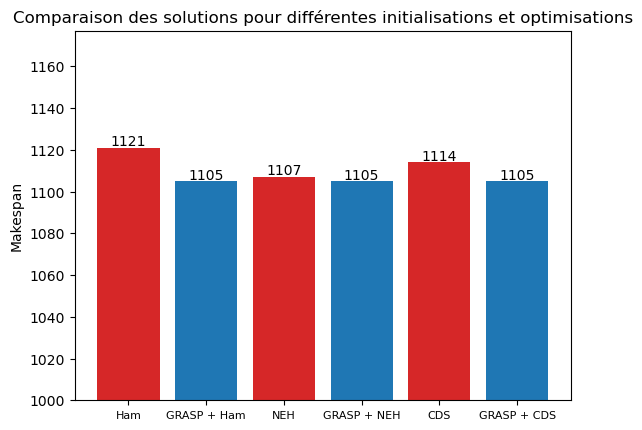

In [17]:
instance=FmCmax.FmCmax_Instance.read_txt("../TP02-Heuristiques/data/random_instance.txt")
processing_times = np.array(instance.P)
max_iter = 100

#Run the algorithms
schedule_ham, makespan_ham = heuristique_Ham(processing_times)
schedule_newGRASP_ham = newGRASP(schedule_ham,processing_times,max_iter)
makespan_newGRASP_ham = compute_makespan(schedule_newGRASP_ham,processing_times)
schedule_neh, makespan_neh = heuristique_NEH(processing_times)
schedule_newGRASP_neh = newGRASP(schedule_neh,processing_times,max_iter)
makespan_newGRASP_neh = compute_makespan(schedule_newGRASP_neh,processing_times)
schedule_cds, makespan_cds = heuristique_CDS(processing_times)
schedule_newGRASP_cds = newGRASP(schedule_cds,processing_times,max_iter)
makespan_newGRASP_cds = compute_makespan(schedule_newGRASP_cds,processing_times)

# Plot the results as a bar chart
labels = ['Ham', 'GRASP + Ham', 'NEH', 'GRASP + NEH','CDS','GRASP + CDS']
makespans = [makespan_ham, makespan_newGRASP_ham, makespan_neh, makespan_newGRASP_neh,makespan_cds,makespan_newGRASP_cds]
colors = ['tab:red','tab:blue','tab:red','tab:blue','tab:red','tab:blue']

plt.bar(labels, makespans, color=colors)
plt.ylabel('Makespan')
plt.title('Comparaison des solutions pour différentes initialisations et optimisations')

plt.xticks(fontsize=8)
# Set the minimum value of the y-axis to 1000
plt.ylim(bottom=1000)

# Add the values as text above the bars
for i, v in enumerate(makespans):
    plt.text(i, v + 1, str(v), ha='center')

plt.show()

### **Instances de Taillard**

### Nombre d'itérations & déviation (pour la nouvelle version)

In [19]:
f =  open("../TP02-Heuristiques/data/Taillard.pkl", "rb")
taillard = pickle.load(f)
max_iter=100
processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
iter=[]
dev=[]
times=[]
for max_iter in range(100,1000,100):
    iter.append(max_iter)
    schedule_neh, makespan_neh = heuristique_NEH(processing_times)
    new_schedule = newGRASP(schedule_neh,processing_times,max_iter)
    makespan= compute_makespan(new_schedule,processing_times)
    dev.append(100*(makespan-upper_bound)/upper_bound)



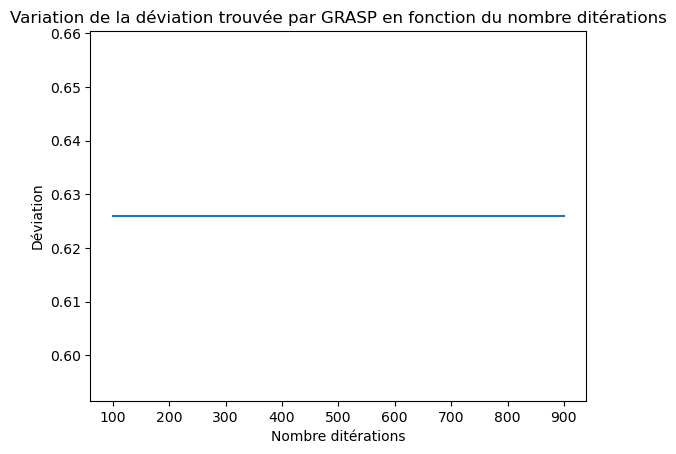

In [20]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(iter, dev)

# Add axis labels and a title
ax.set_xlabel('Nombre ditérations')
ax.set_ylabel('Déviation')
ax.set_title('Variation de la déviation trouvée par GRASP en fonction du nombre ditérations')

# Display the graph
plt.show()

### Résultats obtenus par différentes méthodes d'initialisation 

In [21]:
f =  open("../TP02-Heuristiques/data/Taillard.pkl", "rb")
taillard = pickle.load(f)
max_iter=500
i=0
dev_Ham=[]
dev_NEH=[]
dev_CDS=[]
dev_ham_grasp=[]
dev_neh_grasp=[]
dev_cds_grasp=[]
times_grasp=[]
instances=list(range(1,11))

for i in range(10):
    processing_times = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    schedule_ham, makespan_ham = heuristique_Ham(processing_times)
    schedule_grasp_ham = newGRASP(schedule_ham,processing_times,max_iter)
    makespan_grasp_ham = compute_makespan(schedule_grasp_ham,processing_times)
    schedule_neh, makespan_neh = heuristique_NEH(processing_times)
    start_time = time.time()
    schedule_grasp_neh = newGRASP(schedule_neh,processing_times,max_iter)
    end_time = time. time()
    elapsed_time = end_time - start_time
    makespan_grasp_neh = compute_makespan(schedule_grasp_neh,processing_times)
    schedule_cds, makespan_cds = heuristique_CDS(processing_times)
    start_time = time.time() 
    schedule_grasp_cds = newGRASP(schedule_cds,processing_times,max_iter)
    end_time = time.time() 
    elapsed_time = end_time - start_time
    times_grasp.append(elapsed_time)
    makespan_grasp_cds = compute_makespan(schedule_grasp_cds,processing_times)
    dev_Ham.append(100*(makespan_ham-upper_bound)/upper_bound)
    dev_NEH.append(100*(makespan_neh-upper_bound)/upper_bound)
    dev_CDS.append(100*(makespan_cds-upper_bound)/upper_bound)
    dev_ham_grasp.append(100*(makespan_grasp_ham-upper_bound)/upper_bound)
    dev_neh_grasp.append(100*(makespan_grasp_neh-upper_bound)/upper_bound)
    dev_cds_grasp.append(100*(makespan_grasp_cds-upper_bound)/upper_bound)

In [31]:
dev_ham_grasp=[3.1298904538341157,
  1.030169242089772,
  0.9250693802035153,
  3.480278422273782,
  6.957928802588997,
  1.00418410041841,
  5.4075867635189665,
  12.437810945273633,
  6.260162601626016,
  6.227436823104693]
dev_neh_grasp=[0.6259780907668232,
  0.44150110375275936,
  4.717853839037928,
  2.474864655839134,
  3.3171521035598706,
  2.426778242677824,
  0.9685230024213075,
  1.4096185737976783,
  2.7642276422764227,
  3.88086642599278]
dev_cds_grasp=[3.051643192488263,
  1.3245033112582782,
  5.735430157261795,
  1.6241299303944317,
  1.132686084142395,
  1.5899581589958158,
  4.358353510895884,
  7.960199004975125,
  2.032520325203252,
  2.0758122743682312]
times_grasp=[36.24518656730652,
 20.56029438972473,
 20.441946506500244,
 20.590385913848877,
 20.940468072891235,
 20.606321096420288,
 21.341377019882202,
 20.56865644454956,
 20.92753529548645,
 20.610883474349976]

In [25]:

for i in range(10):
    print(i+1,"&",taillard[i]["ub"],'&&',round(dev_Ham[i],2),'&&',round(dev_ham_grasp[i],2),'&&',round(dev_CDS[i],2),'&&',round(dev_cds_grasp[i],2),'&&',round(dev_NEH[i],2),'&&',round(dev_neh_grasp[i],2),"\\\\")

1 & 1278 && 12.44 && 1.49 && 8.76 && 1.49 && 0.63 && 0.63 \\
2 & 1359 && 9.49 && 1.03 && 4.78 && 1.03 && 0.44 && 0.44 \\
3 & 1081 && 30.16 && 6.66 && 15.54 && 8.14 && 7.22 && 6.66 \\
4 & 1293 && 19.57 && 3.4 && 9.67 && 3.4 && 2.47 && 2.47 \\
5 & 1236 && 11.25 && 1.78 && 7.04 && 1.78 && 5.58 && 1.78 \\
6 & 1195 && 11.55 && 2.01 && 9.79 && 2.01 && 2.76 && 1.34 \\
7 & 1239 && 16.71 && 1.86 && 12.43 && 1.61 && 3.15 && 1.61 \\
8 & 1206 && 23.22 && 3.9 && 11.19 && 6.38 && 1.41 && 1.41 \\
9 & 1230 && 25.04 && 5.12 && 10.57 && 5.12 && 4.96 && 4.96 \\
10 & 1108 && 17.33 && 4.06 && 5.05 && 4.06 && 3.88 && 3.88 \\


In [27]:
for i in range(10):
    print(i+1,"&&")

1 &&
2 &&
3 &&
4 &&
5 &&
6 &&
7 &&
8 &&
9 &&
10 &&


In [29]:

for i in range(10):
    print(round(times_grasp[i],2),"&&")
    # print(i+1,"&",taillard[i]["ub"],'&&',round(dev_Ham[i],2),'&',dev_ham_grasp[i],'&&',round(dev_CDS[i],2),'&',dev_cds_grasp[i],'&&',round(dev_NEH[i],2),'&',dev_neh_grasp[i],"\\\\")

23.19 &&
10.95 &&
11.02 &&
10.82 &&
11.0 &&
10.82 &&
10.89 &&
10.99 &&
11.25 &&
10.86 &&


In [22]:
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)



fig = go.Figure()
fig.add_trace(go.Bar(
    x=instances,
    y=dev_Ham,
    name='Rand',
    marker_color='#176ab4'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_ham_grasp,
    name='Rand+grasp',
    marker_color='#4b9cd3'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_CDS,
    name='CDS',
    marker_color='#6c3483'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_cds_grasp,
    name='CDS+grasp',
    marker_color='#9b59b6'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_NEH,
    name='NEH',
    marker_color='#6b9c34'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_neh_grasp,
    name='NEH+grasp',
    marker_color='#8cc63f'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45, xaxis_title ="Instance", yaxis_title="Deviation (%)", title_text="Déviations obtenues par grasp avec différentes initialisations heuristiques")
fig.show()

# **5. Comparaison entre les 4 algorithmes implémentés** <a class="anchor" id="chapter5"></a>

Arrivés là, nous allons comparer entre les méthodes proposées en termes de :
- Déviation obtenue.
- Temps d'éxécution.

En fixant les paramètres et initialisations comme suit :
- Nombre d'itération : 500.
- Heuristique d'initialisation : CDS.

Les autres paramètres présents dans quelques algorithmes sont initialisés à défaut (ou par la meme valeur déjà utilisée dans les tests précedents).

## **Temps d'exécution** <a class="anchor" id="section_5_1"></a>

In [33]:
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)



fig = go.Figure()
fig.add_trace(go.Bar(
    x=instances,
    y=times_ils,
    name='ILS',
    marker_color='#176ab4'
))
fig.add_trace(go.Bar(
    x=instances,
    y=times_ts,
    name='TS',
    marker_color='#6c3483'
))
fig.add_trace(go.Bar(
    x=instances,
    y=times_gvns,
    name='GVNS',
    marker_color='#9b59b6'
))
fig.add_trace(go.Bar(
    x=instances,
    y=times_grasp,
    name='GRASP',
    marker_color='#6b9c34'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45, xaxis_title ="Instance", yaxis_title="Temps (s)", title_text="Temps d'exécution des différentes méthodes")
fig.show()

## **Déviation** <a class="anchor" id="section_5_2"></a>

In [34]:
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)



fig = go.Figure()
fig.add_trace(go.Bar(
    x=instances,
    y=dev_cds_ils,
    name='ILS',
    marker_color='#176ab4'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_cds_ts,
    name='TS',
    marker_color='#4b9cd3'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_cds_gvns,
    name='GVNS',
    marker_color='#6c3483'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_cds_grasp,
    name='GRASP',
    marker_color='#9b59b6'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45, xaxis_title ="Instance", yaxis_title="Déviation", title_text="Déviations obtenues par les différentes méthodes")
fig.show()